In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('one_way.csv')
df

,Unnamed: 0,weight,group
0,1,4.17,ctrl
1,2,5.58,ctrl
2,3,5.18,ctrl
3,4,6.11,ctrl
4,5,4.50,ctrl
5,6,4.61,ctrl
6,7,5.17,ctrl
7,8,4.53,ctrl
8,9,5.33,ctrl
9,10,5.14,ctrl


## Summary Statistics

In [3]:
stats = df.groupby('group')['weight'].agg(['count', 'std', 'mean'])
stats

,count,std,mean
group,,,
ctrl,10,0.583091,5.032
trt1,10,0.793676,4.661
trt2,10,0.442573,5.526


## Visualization

<AxesSubplot:xlabel='group', ylabel='weight'>

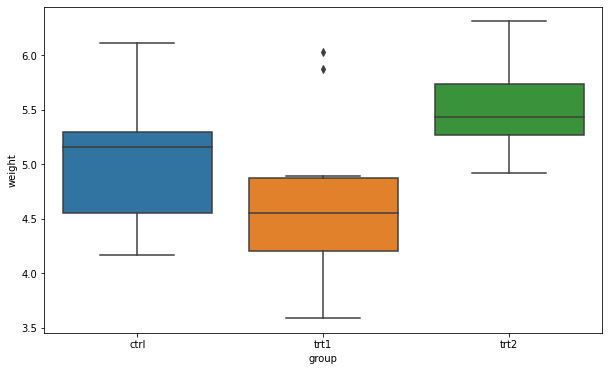

In [4]:
#Create a boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="group", y="weight", data=df)
ax

# Assumptions

### Outliers

In [5]:
def outliers(dep, ind):
    dicts = {'Outliers':{}}
    for ind_cat in pd.unique(df[ind]):
        Q1, Q3 = np.percentile(df[dep][df[ind] == ind_cat], [25,75])
        IQR = Q3-Q1
        lower_fence, upper_fence= Q1-(1.5*IQR), Q3+(1.5*IQR)
        new_dataset = []
        for i in df[dep][df[ind] == ind_cat]:
            if i < lower_fence or i > upper_fence:
                new_dataset.append(i)
        dicts['Outliers'][f'{ind_cat}'] = new_dataset
    return pd.DataFrame(dicts)

In [6]:
outliers('weight', 'group')

,Outliers
ctrl,[]
trt1,"[5.87, 6.03]"
trt2,[]


### Normality

In [7]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('weight ~ group', data=df).fit()

C:\ProgramData\Anaconda3\envs\All\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [8]:
mod.resid

0    -0.862
1     0.548
2     0.148
3     1.078
4    -0.532
5    -0.422
6     0.138
7    -0.502
8     0.298
9     0.108
10    0.149
11   -0.491
12   -0.251
13   -1.071
14    1.209
15   -0.831
16    1.369
17    0.229
18   -0.341
19    0.029
20    0.784
21   -0.406
22    0.014
23   -0.026
24   -0.156
25   -0.236
26   -0.606
27    0.624
28    0.274
29   -0.266
dtype: float64

In [9]:
import scipy.stats as stats
stats.shapiro(mod.resid)

ShapiroResult(statistic=0.9660681486129761, pvalue=0.43789875507354736)

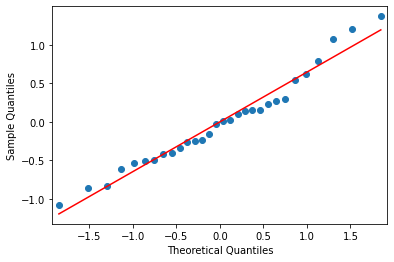

In [10]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import pylab

sm.qqplot(mod.resid, line='r')
pylab.show()

In [11]:
def shapiro(dep, ind):
    normality = {'Shapiro':{}}
    import scipy.stats as stats
    for ind_cat in pd.unique(df[ind]):
        result = stats.shapiro(df[dep][df[ind] == ind_cat])
        normality['Shapiro'][f'{ind_cat}'] = result
    return pd.DataFrame(normality)

In [12]:
shapiro('weight', 'group')

,Shapiro
ctrl,"(0.9566815495491028, 0.7474744915962219)"
trt1,"(0.9304107427597046, 0.4519447386264801)"
trt2,"(0.9410051107406616, 0.5642509460449219)"


### Homogneity of variance

In [13]:
#if normality exists then perform bartlett otherwise levene's tests

In [14]:
# Null Hypothesis: the variances are equal across all samples/groups
# Alternative Hypothesis:  the variances are not equal across all samples/groups

In [15]:
from scipy.stats import bartlett

# subsetting the data:
ctrl = df.query('group == "ctrl"')['weight']
trt1 = df.query('group == "trt1"')['weight']
trt2 = df.query('group == "trt2"')['weight']

# Bartlett's test in Python with SciPy:
stat, p = bartlett(ctrl, trt1, trt2)

# Get the results:
print(stat, p)

2.8785737872360935 0.23709677363455822


## Statsmodels One-Way ANOVA

In [16]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('weight ~ group', data=df).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

            sum_sq    df         F   PR(>F)
group      3.76634   2.0  4.846088  0.01591
Residual  10.49209  27.0       NaN      NaN


#### Calculating Eta-Squared

In [17]:
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0] + aov_table['sum_sq'][1])

aov_table['EtaSq'] = [esq_sm, 'NaN']
print(aov_table)

            sum_sq    df         F   PR(>F)     EtaSq
group      3.76634   2.0  4.846088  0.01591  0.264148
Residual  10.49209  27.0       NaN      NaN       NaN


## Pairwise Comparisons

In [18]:
# multiple pairwise comparisons between groups

In [19]:
# perform Tukey's test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df['weight'], groups=df['group'], alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
ctrl,trt1,-0.371,0.3921,-1.0621,0.3201,False
ctrl,trt2,0.494,0.198,-0.1971,1.1851,False
trt1,trt2,0.865,0.012,0.1739,1.5561,True


## Report

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ctrl vs. trt1: Custom statistical test, P_val:3.921e-01
trt1 vs. trt2: Custom statistical test, P_val:1.200e-02
ctrl vs. trt2: Custom statistical test, P_val:1.980e-01


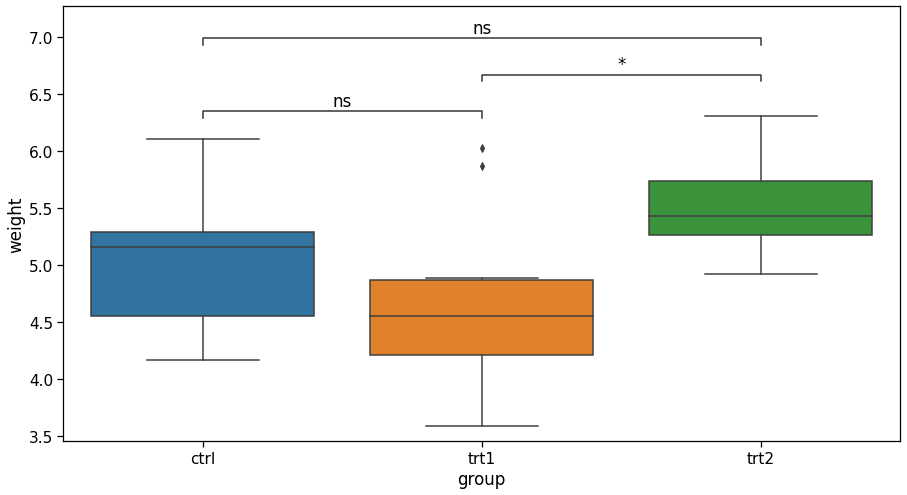

In [20]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, normaltest

pvalues = [0.3921, 0.198, 0.012]

# palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)

# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls
plotting_parameters = {
    'data':    df,
    'x':       'group',
    'y':       'weight',
#     'palette': palette[1:]
}

pairs = [('ctrl', 'trt1'),
         ('ctrl', 'trt2'),
         ('trt1', 'trt2')]

with sns.plotting_context('notebook', font_scale = 1.4):
    
    from matplotlib import pyplot as plt
    plt.figure(figsize=(15,8))

    ax = sns.boxplot(**plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.annotate()

    plt.show()